---
title: Let's build an AI model
subtitle: Using AI, fast
description: Middle school maths is all you need to get started
image: ../images/29_lets_build_an_ai_model/thumbnail.png
author: Salman Naqvi
date: '2025-11-27'
categories: ["Creating Models"]
open-graph:
  description: "Middle school maths is all you need to get started"
  image: ../images/29_lets_build_an_ai_model/thumbnail.png
twitter-card:
  description: Middle school maths is all you need to get started
  image: ../images/29_lets_build_an_ai_model/thumbnail.png
format:
  html: default
filters:
  - line-highlight
---

![](../images/29_lets_build_an_ai_model/thumbnail.png)

:::{.callout-info appearance='simple'}
This notebook is a remix of [fastai Lesson 1](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) by [Jeremy Howard](https://solve.it.com/#im-jeremy-howard-from-fastai), using the writing techniques taught in the [SolveIt course](https://solve.it.com/), led by Jeremy Howard and [Johnothan Whitaker](https://www.johnowhitaker.com/). SolveIt is also a brilliant problem-solving framework and interactive platform, that puts you in control–not the LLM.
:::

## The Requirement

The bar is low. It looks complicated, but it's not. This is the reality to get started making your own AI models:

**Math:** None. Really.

**Data:** You can go miles with only 50 items.

**Computing power:** You can get state of the art computing for free.

**Experience:** If you can write basic code and understand what a function is, you're ready.

Just kidding–these aren't the real requirements. The real requirement is being okay with not understanding everything immediately. You'll learn by doing first, understanding later.

When you play soccer, do you sit in a physics classroom or starting kicking a ball?

## Let's Kick the Ball

To get started:
- Head to [Kaggle](kaggle.com), sign up, and verify your phone number (that's how you get access to fancy GPUs)
- Create a notebook
- Then in the first cell, run `!uv pip install ddg`–this is just setting up the equipment in the soccer pitch

In 2015, this XKCD comic made a joke: distinguishing birds from non-birds in photos was "nearly impossible" for computers. Everyone laughed because it was obvioulsy true.

![](https://imgs.xkcd.com/comics/tasks.png)

Let's build that exact system, in minutes. If you think it'll be hard, it'll be hard. If you think it'll be easy, it'll be easy.

We'll need to:
1. Get some data
2. Process the data
3. Fine-tune an AI model
4. Use the model

In [1]:
! uv pip install ddgs

Using Python 3.11.13 environment at: /usr
Resolved 17 packages in 370ms                                        
Prepared 4 packages in 229ms                                             
Uninstalled 1 package in 21ms
Installed 4 packages in 11ms                                
 + ddgs==9.8.0
 - lxml==5.4.0
 + lxml==6.0.2
 + primp==0.15.0
 + socksio==1.0.0


In [2]:
import logging
logging.disable(logging.WARNING)

### Step 1: Getting some Images

We need some images to teach the model what's a bird and what's a first.

Rather than manually searching for photos by hand, let's programmatically do it.

First, let's search for a single photo to make sure our search works.

In [5]:
from ddgs import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200):
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

urls = search_images('bird photos', max_images=1)

Let's download it and have a look.

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

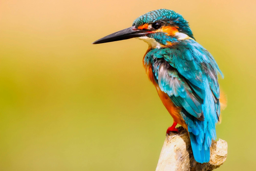

In [4]:
from fastdownload import download_url
from fastai.vision.all import *

download_url(urls[0], 'bird.jpg', show_progress=False)
im = Image.open('bird.jpg')
im.to_thumb(256,256)

Now grab 200 bird photos and 200 forest photos (our 'not bird' category).

In [6]:
searches = 'forest', 'bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

### Step 2: Create a DataBlock

Here, we'll be performing a bunch of processes on the data.

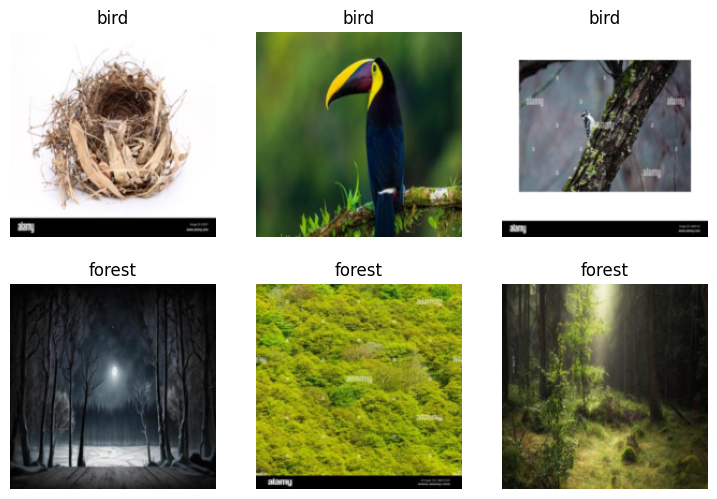

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

What this means:
- **blocks**: inputs are images, outputs are categories
- **get_items**: find all image files
- **splitter**: randomly hold out 20% for testing
- **get_y**: label comes from folder name (bird/forest)
- **item_tfms**: resize everything to 192×192

### Step 3: Train

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.928233,0.830080,0.205128,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.421934,0.592662,0.153846,00:14
1,0.265431,0.519274,0.128205,00:14
2,0.191559,0.445995,0.102564,00:14


Done. You trained a model.

### Step 4: Use the Model

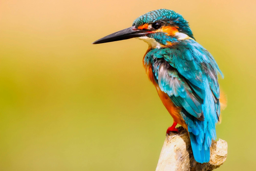

In [11]:
im.to_thumb(256,256)

In [9]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


That's it. From joke to reality.

## What Just Happened?

**Datasets and splits**

We used DuckDuckGo to find image URLs, then downloaded them. You created your very own dataset.

```py
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)
```

Machine learning models need two things: data to learn from (training set) and data to test accuracy (validation set). We split our 400 images 80/20:

```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

The model never sees validation images during training. This tells us if it actually learned or just memorized.

**DataBlocks and DataLoaders**

A `DataBlock` is a block of data. It says "here's how to handle my data":

```python
DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # what type of data
    get_items=get_image_files,           # how to find it
    splitter=RandomSplitter(...),        # how to split it
    get_y=parent_label,                  # how to label it
    item_tfms=[Resize(192, ...)]         # how to transform it
)
```

Think of it like a crate with items inside. The crate has a sticker informing us how to handle the items within.

Think of `.dataloaders` like the dude unpacking the crate. 

```python
DataBlock(
    ...
).dataloaders(path, bs=32)
```

`bs`, short for batch size, tells the dude how many items to unpack from the crate and put at the shelf at any given moment.

More technically, `DataLoaders` turns this block into actual iterators that feed batches of data to your model during training.

**Pre-trained models**

You may have noticed that our `vision_learner` was passed `resnet18`. This is an already existing model, already trained on ImageNet—1 million images across 1000 categories. It already knows edges, textures, shapes, even some animals.

```python
learn = vision_learner(dls, resnet18, metrics=error_rate)
```

When you create a learner, fastai downloads those pre-trained weights automatically.

**Fine-tuning**

You're not training from scratch. You're adjusting an expert:

```python
learn.fine_tune(3)
```

Models have something called weights. They guide the model to the correct answer. For our case, that's bird or forest. In three loops, the model tweaks the weights so it getes better at determining what's a bird and what's a forest.

The model already knows "bird-like features." You're just teaching it: "these specific birds, not those specific forests."

That's why it can take 30 seconds instead of 30 hours.

**Predictions**

```python
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
```

Returns three things: the predicted label, the label index, and probabilities for each category.

**The process, start to finish:**

1. **Collect data** – Download images, organize into folders by category
3. **Process Data** – Tell fastai: input type, output type, how to find files, how to split, how to label
4. **Load Data** – Package the data into batches the model can consume
5. **Create learner** – Combine your data with a pre-trained model (like resnet18)
6. **Fine-tune** – Adjust the pre-trained weights to your specific task
7. **Predict** – Use the trained model on new images

This pattern works for almost any image classification problem. Different images, same steps.

## Beyond Birds

The same six-step pattern works for completely different problems.

**Segmentation** – Label every pixel in an image by what it represents. Point at a road scene and the model colors cars brown, roads gray, buildings red, sky blue. Same process: organize pixel-labeled images, create DataLoaders, use a segmentation learner, fine-tune.

**Tabular data** – Predict outcomes from spreadsheets. Will this customer churn? What salary range fits these demographics? Organize your CSV, tell fastai which columns are categories vs numbers, create a tabular learner, fit. No pre-trained models here—every table is unique.

**Collaborative filtering** – Recommend products based on what similar users liked. "Users who rated movie X highly also liked movie Y." Organize user-item-rating data, create collaborative filtering DataLoaders, fine-tune. This powers Netflix, Spotify, Amazon.

**Text classification** – Detect sentiment, filter spam, categorize documents. Organize labeled text, create text DataLoaders, use a text classifier (pre-trained on Wikipedia), fine-tune to your specific task.

Different domains, same structure. The pattern is portable.

For detailed examples, see the [fastai docs](https://docs.fast.ai/).

## Your Turn

You now know enough to build your own classifier. Pick something you care about:

- Healthy vs diseased plants
- Your handwriting vs someone else's
- Cats vs dogs (classic, but effective)
- Different types of clouds
- Your face vs not your face

The steps are the same:

1. Search and download 50-200 images per category
2. Create a DataBlock
3. Make DataLoaders and check with `show_batch()`
4. Create a vision learner with resnet18
5. Fine-tune for 3-5 epochs
6. Test predictions

Start simple. Two categories. Small dataset. Get something working in the next hour.

**What to do next:**

- Read [Chapter 1 of the fastai book](https://github.com/fastai/fastbook) - same material, different angle
- Try the [official fastai course](https://course.fast.ai/) for video walkthroughs
- Share your project on the [fastai forums](https://forums.fast.ai/) - the community is helpful and encouraging

Don't wait until you understand everything. Build first, understand later. That's how you actually learn.

---

If you have any comments, questions, suggestions, feedback, criticisms, or corrections, please do post them down in the comment section below!